In [1]:
import pandas as pd

In [60]:
df = pd.read_csv("GSE225001_ht1_gene_expression.csv",index_col=0)

In [61]:
df.head()

,GSM7036843,GSM7036844,GSM7036845,GSM7036846,GSM7036847,GSM7036848
Gene Symbol,,,,,,
0610005C13Rik,424.61,362.04,396.18,261.38,284.05,272.48
0610007C21Rik,413.00,380.04,401.71,335.46,367.09,249.00
0610007L01Rik,362.04,354.59,385.34,666.29,584.07,580.04
0610007N19Rik,36.50,40.22,44.32,48.50,34.54,35.26
0610007P08Rik,84.45,73.01,82.71,104.69,118.60,95.01


In [63]:
import numpy as np
!pip install scipy
from scipy.stats import ttest_ind

In [64]:
control_samples = df.loc[:, ["GSM7036843","GSM7036844","GSM7036845"]]  # control columns
disease_samples = df.loc[:, ["GSM7036846","GSM7036847","GSM7036848"]]  # disease columns

In [65]:
control_samples.head()

,GSM7036843,GSM7036844,GSM7036845
Gene Symbol,,,
0610005C13Rik,424.61,362.04,396.18
0610007C21Rik,413.00,380.04,401.71
0610007L01Rik,362.04,354.59,385.34
0610007N19Rik,36.50,40.22,44.32
0610007P08Rik,84.45,73.01,82.71


In [66]:
disease_samples.head()

,GSM7036846,GSM7036847,GSM7036848
Gene Symbol,,,
0610005C13Rik,261.38,284.05,272.48
0610007C21Rik,335.46,367.09,249.00
0610007L01Rik,666.29,584.07,580.04
0610007N19Rik,48.50,34.54,35.26
0610007P08Rik,104.69,118.60,95.01


In [67]:
p_values = []
log2_fc = []

for gene in df.index:
    control_expr = control_samples.loc[gene]
    disease_expr = disease_samples.loc[gene]
    # Perform t-test
    stat, p = ttest_ind(control_expr, disease_expr, equal_var=False)
    p_values.append(p)
     # Calculate log2 fold change
    fc = disease_expr.mean() / control_expr.mean()
    log2_fc.append(np.log2(fc))
# Store results in DataFrame
deg_results = pd.DataFrame({"Gene": df.index, "log2FC": log2_fc, "p-value": p_values})

/srv/conda/envs/notebook/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:586: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


In [68]:
deg_results.head()

,Gene,log2FC,p-value
0,0610005C13Rik,-0.532229,0.013267
1,0610007C21Rik,-0.328357,0.140416
2,0610007L01Rik,0.732074,0.007917
3,0610007N19Rik,-0.033034,0.868736
4,0610007P08Rik,0.406331,0.043085


In [69]:
!pip install statsmodels
from statsmodels.stats.multitest import multipletests

# Adjust p-values using Benjamini-Hochberg (FDR)
deg_results["adj_p-value"] = multipletests(deg_results["p-value"], method="fdr_bh")[1]

In [70]:
deg_results.head()

,Gene,log2FC,p-value,adj_p-value
0,0610005C13Rik,-0.532229,0.013267,0.182774
1,0610007C21Rik,-0.328357,0.140416,0.419275
2,0610007L01Rik,0.732074,0.007917,0.151973
3,0610007N19Rik,-0.033034,0.868736,0.935311
4,0610007P08Rik,0.406331,0.043085,0.266879


In [71]:
# Set thresholds for significance
log2fc_threshold = 1.0  # At least 2-fold change
pval_threshold = 0.05   # Statistically significant

deg_filtered = deg_results[
    (abs(deg_results["log2FC"]) > log2fc_threshold) & (deg_results["adj_p-value"] < pval_threshold)
]
deg_filtered.to_csv("deg_filtered.csv")
print(deg_filtered)

              Gene    log2FC   p-value  adj_p-value
2512         Abcc2  1.563959  0.000039     0.041480
2956       Akr1c13  2.218683  0.000111     0.048690
2973         Alas1  1.557613  0.000088     0.048690
4142         Blvrb  1.908329  0.000022     0.041480
4262          Btg3  2.102020  0.000010     0.033533
4406           C4b -1.816539  0.000108     0.048690
4416            C6 -2.838346  0.000001     0.026402
4441           C8b -3.810002  0.000095     0.048690
4443            C9 -2.086170  0.000097     0.048690
4648          Cbr1  2.881557  0.000093     0.048690
5021      Cdc42se1  1.459559  0.000115     0.048690
5117          Cds2  1.715644  0.000111     0.048690
5218         Ces2c  2.651615  0.000114     0.048690
5224         Ces3a -2.381326  0.000119     0.048690
5809         Creg1  1.718377  0.000090     0.048690
6104        Cyp2a5  4.286465  0.000012     0.033533
6239   D16Ertd472e  1.444111  0.000010     0.033533
6738         Dmgdh -1.182012  0.000119     0.048690
7438        

In [72]:
deg_filtered["log2FC"].dtype

dtype('float64')

In [73]:
!pip install matplotlib
!pip install seaborn
import matplotlib.pyplot as plt
import seaborn as sns

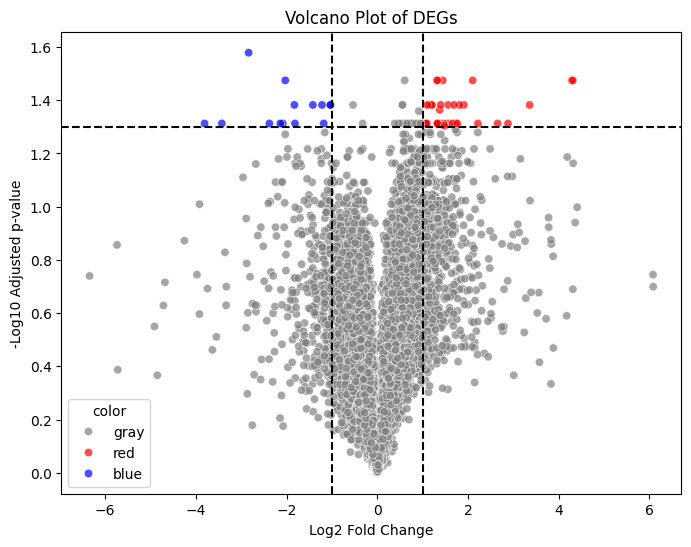

In [74]:
# Assign colors for up/down-regulated genes
deg_results["color"] = "gray"
deg_results.loc[(deg_results["log2FC"] > log2fc_threshold) & (deg_results["adj_p-value"] < pval_threshold), "color"] = "red"
deg_results.loc[(deg_results["log2FC"] < -log2fc_threshold) & (deg_results["adj_p-value"] < pval_threshold), "color"] = "blue"

plt.figure(figsize=(8,6))
sns.scatterplot(x="log2FC", y=-np.log10(deg_results["adj_p-value"]), hue=deg_results["color"], palette={"red":"red", "blue":"blue", "gray":"gray"}, alpha=0.7,data=deg_results)
plt.axhline(-np.log10(pval_threshold), linestyle="--", color="black")
plt.axvline(-log2fc_threshold, linestyle="--", color="black")
plt.axvline(log2fc_threshold, linestyle="--", color="black")
plt.xlabel("Log2 Fold Change")
plt.ylabel("-Log10 Adjusted p-value")
plt.title("Volcano Plot of DEGs")
plt.savefig("volcano_plot.jpg", dpi=300, bbox_inches="tight", format="jpg")
plt.show()

In [75]:
deg_results.to_csv("deg_results_225001.csv")

In [76]:
plt.savefig("volcano_plot_225001.jpg", dpi=300, bbox_inches="tight", format="jpg")

<Figure size 640x480 with 0 Axes>